### Project 1 - Predicting Exoplanets <mark> with **PyCaret**</mark>

#### David Kinney - DSS 680 - Spring 2021 - Professor Catherine Williams

In [ ]:
# %% Import libraries
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import seaborn as sns
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, \
                                    cross_val_score, \
                                    cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, \
                                    accuracy_score, \
                                    precision_score, \
                                    recall_score, \
                                    classification_report
from tpot import TPOTClassifier

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# function definitions

def pca(df):
    
    # standardize the features matrix
    features = StandardScaler().fit_transform(df)
    
    # Create a PCA that retains 99% of the variance
    pca = PCA(n_components = 0.95)
    features_pca = pca.fit_transform(features)
    
    return features, features_pca


def plot_cm(cm):
    # plot confusion matrix
    fig, ax = plt.subplots(figsize = (10,8))
    
    sns.heatmap(conf_matrix_rf/np.sum(conf_matrix_rf), annot=True, 
                fmt='.2%', cmap='Blues', annot_kws={'size':15})
    
    ax.set_title('Random Forest Confusion Matrix', fontsize = 18, loc='left')
    
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12)
    
    plt.show()

In [1]:
# Read the Kepler Objects of Interest (KOI) df_final and look at one observation
import pandas as pd

df_koi = pd.read_csv('../data/cumulative_2021.03.16_17.10.21.csv')
print(df_koi.shape)
print(df_koi[1:2].T)

(9564, 141)
                               1
rowid                          2
kepid                   10797460
kepoi_name             K00752.02
kepler_name         Kepler-227 c
koi_disposition        CONFIRMED
...                          ...
koi_dikco_mra_err           0.34
koi_dikco_mdec              0.12
koi_dikco_mdec_err          0.73
koi_dikco_msky               0.5
koi_dikco_msky_err          0.45

[141 rows x 1 columns]


#### clean data  

In [2]:
# Remove variables with no data
df_koi_cleaned = df_koi.dropna(axis=1, how='all')
# Remove variables with no data
df_koi_cleaned = df_koi_cleaned.loc[:, (df_koi_cleaned != 0).any(axis=0)]
# Remove the err columns
df_koi_cleaned = df_koi_cleaned[df_koi_cleaned.columns.drop(
    list(df_koi_cleaned.filter(regex='_err')))]
# Still some variables that are all 0.0; will just drop them manually...
cols = ['koi_eccen','koi_ldm_coeff4','koi_ldm_coeff3']
df_koi_cleaned = df_koi_cleaned.drop(cols,axis=1)

In [ ]:
df_koi_cleaned.shape
# %% describe
df_describe = pd.DataFrame(df_koi_cleaned.describe())
print(df_describe)

#### prepare data

In [3]:
"""
Remove all descriptive variables to further simplify the df_final
In the interest of time, remove all categorical variables
"""
remove_cols = ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_vet_stat',
               'koi_vet_date', 'koi_fpflag_nt',
               'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_disp_prov',
               'koi_comment', 'koi_limbdark_mod', 'koi_parm_prov', 'koi_tce_delivname',
               'koi_trans_mod', 'koi_trans_mod', 'koi_datalink_dvr', 'koi_datalink_dvs',
               'koi_sparprov', 'koi_fittype']
df_final = df_koi_cleaned.drop(remove_cols, axis=1)

In [ ]:
# Separate labels from features
labels = df_final['koi_disposition']
df_features = df_final.drop(['koi_disposition'], axis=1)

imputer = SimpleImputer(strategy="median")
imputer.fit(df_features)
X = imputer.transform(df_features)
df_final = pd.DataFrame(X, columns=df_features.columns, index=df_features.index)

## Pardon the interruption...

#### pycaret

In [4]:
from pycaret.classification import setup
from pycaret.classification import compare_models

# setup the dataset
grid = setup(data=df_final, target='koi_disposition', session_id=42)

,Description,Value
0,session_id,42
1,Target,koi_disposition
2,Target Type,Multiclass
3,Label Encoded,"CANDIDATE: 0, CONFIRMED: 1, FALSE POSITIVE: 2"
4,Original Data,"(9564, 55)"
5,Missing Values,True
6,Numeric Features,51
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [5]:
# evaluate models and compare models
best = compare_models()
# report the best model
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9289,0.9885,0.9032,0.9293,0.9288,0.8852,0.8854,0.3860
rf,Random Forest Classifier,0.9253,0.9869,0.8983,0.9256,0.9252,0.8794,0.8796,0.2130
gbc,Gradient Boosting Classifier,0.9249,0.9881,0.8978,0.9256,0.9247,0.8786,0.8790,2.8310
xgboost,Extreme Gradient Boosting,0.9244,0.9882,0.8972,0.9250,0.9243,0.8779,0.8782,1.2960
et,Extra Trees Classifier,0.9157,0.9855,0.8853,0.9161,0.9156,0.8639,0.8642,0.0960
dt,Decision Tree Classifier,0.8909,0.9275,0.8521,0.8912,0.8909,0.8240,0.8241,0.0460
lda,Linear Discriminant Analysis,0.8718,0.9709,0.8254,0.8731,0.8714,0.7930,0.7939,0.0380
knn,K Neighbors Classifier,0.6179,0.7859,0.5862,0.6278,0.6212,0.3936,0.3948,0.0480
ada,Ada Boost Classifier,0.5271,0.8547,0.5595,0.7479,0.5325,0.3324,0.3746,0.2060
svm,SVM - Linear Kernel,0.3777,0.0000,0.3333,0.1604,0.2208,0.0000,0.0000,0.0880


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [6]:
# tune model hyperparameters on the sonar classification dataset
# from sklearn.ensemble import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from pycaret.classification import setup
from pycaret.classification import tune_model

# grid = setup(data=train_features, target=train_labels, html=False, silent=True, verbose=False)
# tune model hyperparameters
best = tune_model(LGBMClassifier(), n_iter=200, choose_better=True)
# report the best model
print(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9254,0.9865,0.8994,0.9259,0.9254,0.8796,0.8798
1,0.9284,0.9883,0.9024,0.9286,0.9283,0.8844,0.8845
2,0.9433,0.9914,0.9228,0.9433,0.9433,0.9085,0.9085
3,0.9284,0.9893,0.9024,0.9285,0.9283,0.8844,0.8844
4,0.9283,0.9903,0.9024,0.9286,0.9281,0.8842,0.8844
5,0.9417,0.9916,0.9205,0.9419,0.9417,0.9059,0.9059
6,0.9312,0.9901,0.9063,0.9315,0.9312,0.8890,0.8891
7,0.9253,0.9864,0.8980,0.9253,0.9251,0.8792,0.8794
8,0.9178,0.9875,0.8879,0.9176,0.9177,0.8671,0.8672
9,0.9283,0.9860,0.9021,0.9291,0.9280,0.8840,0.8845


LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=100, min_child_weight=0.001,
               min_split_gain=0.6, n_estimators=210, n_jobs=-1, num_leaves=100,
               objective=None, random_state=None, reg_alpha=0.3,
               reg_lambda=0.05, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


#### train baseline model

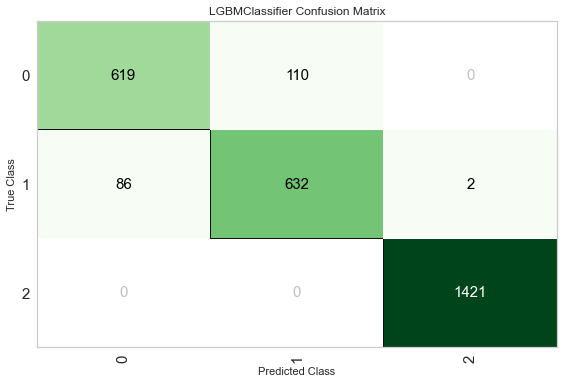

In [9]:
from pycaret.classification import plot_model, evaluate_model, interpret_model, predict_model
plot_model(best, plot = 'confusion_matrix')

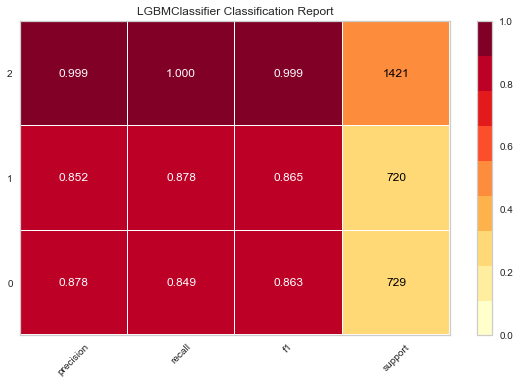

In [10]:
plot_model(best, plot = 'class_report')

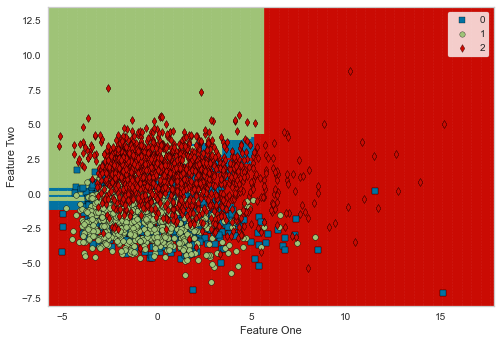

In [11]:
plot_model(best, plot = 'boundary')

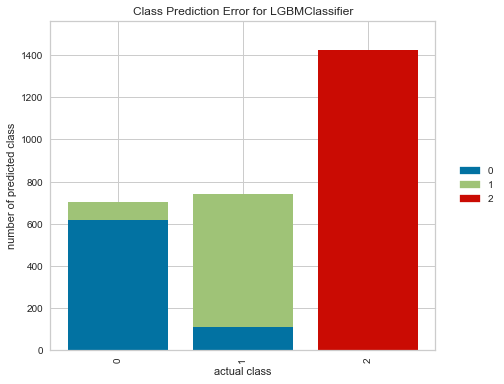

In [12]:
plot_model(best, plot = 'error')

In [13]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

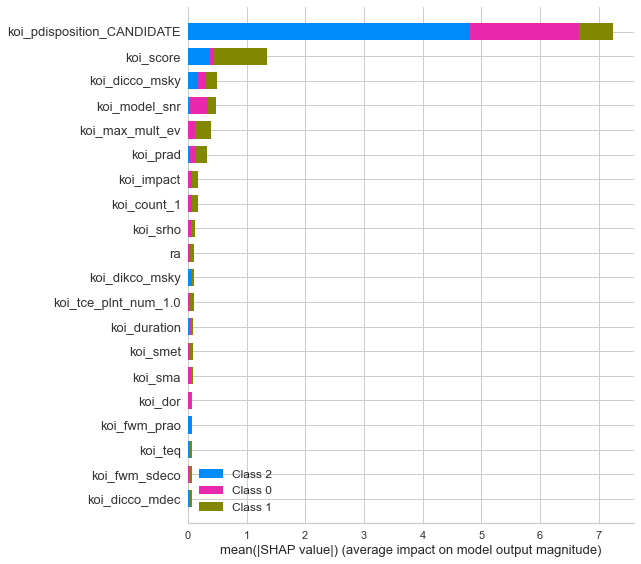

In [16]:
interpret_model(best)

In [15]:
predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9310,0.9900,0.9090,0.9311,0.9310,0.8900,0.8901


,koi_score,koi_period,koi_time0,koi_impact,koi_duration,koi_depth,koi_srho,koi_prad,koi_sma,koi_incl,...,koi_tce_plnt_num_3.0,koi_tce_plnt_num_4.0,koi_tce_plnt_num_5.0,koi_tce_plnt_num_6.0,koi_tce_plnt_num_7.0,koi_tce_plnt_num_8.0,koi_tce_plnt_num_not_available,koi_disposition,Label,Score
0,0.477634,2.421869,2454965.75,0.76947,6.22000,24212.679688,8.975136,131.092224,0.226298,82.532745,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CANDIDATE,CANDIDATE,0.9919
1,1.000000,10.005070,2454969.75,0.14800,3.48100,143.000000,2.002420,1.110000,0.087300,89.610001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CANDIDATE,CANDIDATE,0.8763
2,1.000000,8.689301,2454966.75,0.02900,2.56300,1120.000000,4.752150,2.920000,0.077400,89.940002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONFIRMED,CONFIRMED,0.9771
3,0.000000,22.841562,2454971.75,1.26700,2.59970,2940.000000,0.772200,30.000000,0.149900,87.379997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FALSE POSITIVE,FALSE POSITIVE,0.9994
4,0.000000,1.890227,2454964.75,0.95700,3.85500,112000.000000,0.467270,42.049999,0.028500,77.589996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FALSE POSITIVE,FALSE POSITIVE,0.9991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,0.000000,0.941841,2454964.75,1.19800,5.06000,388.000000,0.040960,27.049999,0.018900,15.520000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FALSE POSITIVE,FALSE POSITIVE,0.9996
2866,0.116000,456.553070,2455360.25,0.67300,4.43500,116.000000,18.903070,1.480000,1.117000,89.930000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FALSE POSITIVE,FALSE POSITIVE,0.9988
2867,0.000000,0.843651,2454965.00,0.40500,2.80468,305000.000000,1.154570,39.980000,0.015300,83.379997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FALSE POSITIVE,FALSE POSITIVE,0.9996
2868,1.000000,0.558841,2454964.50,0.30700,0.79180,281.000000,8.804430,1.330000,0.012800,86.650002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CANDIDATE,CONFIRMED,0.6111


### AutoML

In [ ]:
automl_model = automl(optimize = 'MAE')
pred_holdouts = predict_model(automl_model)
pred_holdouts.head()

In [ ]:
new_data = features.copy()
new_data.drop(['koi_disposition'], axis=1, inplace=True)
predictions = predict_model(automl_model, data=new_data)
predictions.head()

In [ ]:
!mlflow ui